## imports, etc.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import os
from sklearn.semi_supervised import LabelPropagation
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [3]:
Xv_train = torch.load("data/FashionMNIST_train_latent.pt")
Xv_test = torch.load("data/FashionMNIST_test_latent.pt")
Xv = torch.cat((Xv_train, Xv_test), 0)
y_train = torch.load("data/FashionMNIST_train_labels.pt")
y_test = torch.load("data/FashionMNIST_test_labels.pt")
y = torch.cat((y_train, y_test), 0)

In [4]:
Xa_train = torch.load("data/AE_train.pt")
Xa_test = torch.load("data/AE_test.pt")
Xa = torch.cat((Xa_train, Xa_test), 0).detach().cpu()

In [5]:
os.chdir("../fashion_ml")

In [6]:
from fashion_vae import FashionVAE
from data_loader import EZ_Dataloader
from experiment import FashionML

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [108]:
trainset = torchvision.datasets.FashionMNIST(root = "./data", train = True,
                                             download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root = "./data", train = False,
                                            download = True, transform = transforms.ToTensor())

In [109]:
Xf_train = trainset.data
yf_train = trainset.targets
Xf_test = testset.data
yf_test = testset.targets

In [110]:
Xf = torch.cat((Xf_train, Xf_test), 0)
yf = torch.cat((yf_train, yf_test), 0)

In [111]:
Xf = torch.reshape(Xf, (70000, 784))

In [2]:
#np.random.seed(0)

## limit data labels

discard all but 200 random labels (we can increase the number but I feel like 1000+ doesn't really count as semi-supervised anymore)

In [8]:
n_labeled = 200

In [9]:
ind = np.random.randint(len(Xv), size=(n_labeled))
y_lim = np.repeat(-1, len(y))
y_lim[ind] = y[ind]

## compare: clustering

VAE - search for optimal k: 2 is optimal, anything over 3 predicts everything as the first class

In [10]:
def test_knn(X, y, n):
    lpm = LabelPropagation(kernel='knn',n_neighbors=n,n_jobs=-1,max_iter=5000)
    lpm.fit(X, y_lim)
    print(lpm.score(X, y))
    y_pred = lpm.predict(X)
    print(np.unique(y_pred))
    return lpm

In [11]:
test_knn(Xv, y, 2)

0.1028
[0 1 2 3 4 5 6 7 8 9]


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1, n_neighbors=2)

In [12]:
test_knn(Xv, y, 3)

0.1013
[0 1 2 3 4 5 6 7 8 9]


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1, n_neighbors=3)

In [13]:
test_knn(Xv, y, 7)

0.1
[0]


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1)

AE - search for optimal k: 2 still best. and accuracy is slightly better than for vae? 

In [12]:
test_knn(Xa, y, 2)

0.10335714285714286
[0 1 2 3 4 5 6 7 8 9]


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1, n_neighbors=2)

In [13]:
test_knn(Xa, y, 3)

0.10194285714285714
[0 1 2 3 4 5 6 7 8 9]


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1, n_neighbors=3)

In [14]:
test_knn(Xa, y, 7)

0.1
[0]


LabelPropagation(kernel='knn', max_iter=5000, n_jobs=-1)

## compare: mlp

test a few networks on vae latent representations

In [13]:
Xv_train = Xv[y_lim != -1]
Xv_test = Xv[y_lim == -1]
y_train = y[y_lim != -1]
y_test = y[y_lim == -1]

In [18]:
clf = MLPClassifier(hidden_layer_sizes=(100,20,5), tol=1e-4)
clf.fit(Xv_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 20, 5))

In [19]:
clf.score(Xv_test, y_test)

0.4000859598853868

In [22]:
clf = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-5)
clf.fit(Xv_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 100, 25, 5), tol=1e-05)

In [23]:
clf.score(Xv_test, y_test)

0.479054441260745

test same networks on vanilla ae

In [15]:
Xa_train = Xa[y_lim != -1]
Xa_test = Xa[y_lim == -1]
y_train = y[y_lim != -1]
y_test = y[y_lim == -1]

In [16]:
clf = MLPClassifier(hidden_layer_sizes=(100,20,5), tol=1e-4)
clf.fit(Xa_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 20, 5))

In [18]:
clf.score(Xa_test, y_test)

0.38530085959885385

In [21]:
clf = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-5)
clf.fit(Xa_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 100, 25, 5), tol=1e-05)

In [22]:
clf.score(Xa_test, y_test)

0.531704871060172

## test different numbers of points

In [122]:
ns = [30, 50, 75, 100, 150, 200, 500, 750, 900, 1000, 1100, 1250, 1500, 1750, 2000]

In [123]:
def rep(n, X_dat, y_dat, c):
    ind = np.random.randint(len(y_dat), size=(n))
    y_lim = np.repeat(-1, len(y_dat))
    y_lim[ind] = y[ind]
    X_train = X_dat[y_lim != -1]
    X_test = X_dat[y_lim == -1]
    y_train = y_dat[y_lim != -1]
    y_test = y_dat[y_lim == -1]
    if c:
        clf = MLPClassifier(hidden_layer_sizes=(25,10,5), tol=1e-5)
    else:
        clf = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-5)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [124]:
def test_mlp(n, X_dat, y_dat, c=False):
    max_score = rep(n, X_dat, y_dat, c)
    for i in range(4):
        score = rep(n, X_dat, y_dat, c)
        if score > max_score:
            max_score = score
    return max_score

In [125]:
res = []
res2 = []
res3 = []

In [126]:
for n in ns:
    res.append(test_mlp(n, Xv, y))
    res2.append(test_mlp(n, Xa, y))
    res3.append(test_mlp(n, Xf, yf))

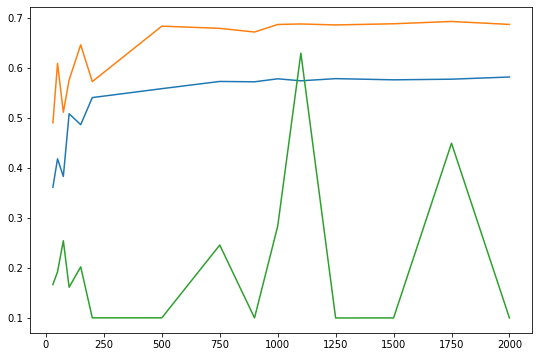

In [127]:
plt.figure(figsize=(9,6))
plt.plot(ns, res)
plt.plot(ns, res2)
plt.plot(ns, res3)
plt.show()

On average, the VAE latent representations acheive better scores. For both latent representations, adding more data after about 1000 points does not make a big difference. This type of model is not working very well for the raw images. Below I model them separately with a more appropriate mlp model.

In [128]:
ns_new = [30, 50, 75, 100, 150, 200, 500, 750, 1000, 1500]

In [129]:
res_ = []
res2_ = []
res3_ = []

In [130]:
for n in ns_new:
    res_.append(test_mlp(n, Xv, y))
    res2_.append(test_mlp(n, Xa, y))
    res3_.append(test_mlp(n, Xf, yf, True))

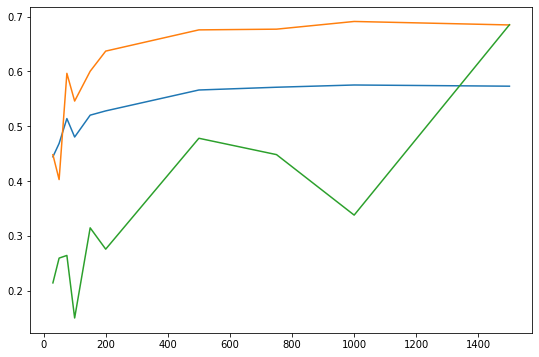

In [131]:
plt.figure(figsize=(9,6))
plt.plot(ns_new, res_)
plt.plot(ns_new, res2_)
plt.plot(ns_new, res3_)
plt.show()